In [1]:
import numpy as np
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import *
from src.gmm import *
from src.contact_space import *


print("=== 初始化数据和模型 ===")

# 1. 获取关键接触点
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠
msa_seq = 'EVSDKRT-CVSLTTQRLPVSRIKTYTIT---EGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNT'
results = calculate_contact_difference_msa_id(chemokine_pdb, alternate_pdb,msa_seq,threshold=10.0,remove_diag=5)
critical_contacts = results['critical_contacts']
pdb_to_msa = results['pdb_to_msa_map']
msa_to_pdb_map = {msa_id: pdb_id for pdb_id, msa_id in pdb_to_msa.items()}
print(f"关键接触点数量: {len(critical_contacts)}")



# 2. 加载MJ矩阵
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")

# 3. 生成contact embedding

contact_space = ContactSpace(critical_contacts, mj_dict)

# 批量添加节点
path_dir = "/yezhirui/evo_probe/data/sample"
node_configs = [("ANC0", f"{path_dir}/node499_anc0_samples.fasta"),("ANC1", f"{path_dir}/node500_anc1_samples.fasta"),
("ANC2", f"{path_dir}/node501_anc2_samples.fasta"), ("ANC3", f"{path_dir}/node502_anc3_samples.fasta"), ("ANC4", f"{path_dir}/node507_anc4_samples.fasta")]
for node_id, fasta_path in node_configs:
    contact_space.add_node_from_fasta(node_id, fasta_path)

contact_space.build_embeddings()

anc0_contact_embedding = contact_space.get_node_embeddings("ANC0")
anc1_contact_embedding = contact_space.get_node_embeddings("ANC1")
anc2_contact_embedding = contact_space.get_node_embeddings("ANC2")
anc3_contact_embedding = contact_space.get_node_embeddings("ANC3")
anc4_contact_embedding = contact_space.get_node_embeddings("ANC4")

=== 初始化数据和模型 ===
PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
警告: MSA序列比PDB序列长，MSA位置61(R)无对应PDB残基
PDB到MSA映射完成: 57 个残基 (匹配: 57, 不匹配: 0)
PDB序列长度: 60, MSA序列长度: 70
接触对转换完成: 109 个有效接触对, 2 个跳过
接触对转换完成: 133 个有效接触对, 0 个跳过
关键接触点数量: 242


In [2]:
anc4_optimal = "EVLEKSIKCVSLTTQRLPINNIKTYTIKSNEEGSMKAVIFITRRGLKICADPQAKWVKKAVKTIDRKTRT"
anc3_optimal = "EVMKKSIKCVSLTTQRLPINSIKTYTIQSNEEGSMKAVIFITRRGIKICANPEAKWVKKAIKTIDRRTTT"
anc0_optimal = "ANTRSNCRCLRYTKRPLPLKRIKSYTIQSNEACNIKAIIFTTKKGRKICANPNEKWVQKAIKHLDKKSKK"
anc1_optimal = anc0_optimal
anc2_optimal = "EVMRKSVRCLKYTTQRLPLKRIKSYTIQSNEECNIKAIIFTTKKGRKICANPEEKWVKKAIKHLDRKAKK"
xcl1_seq = "EVSDKRT-CVSLTTQRLPVSRIKTYTIT---EGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNT"




embeddings, indices = contact_space.get_embeddings_by_sequences(
    [anc0_optimal,anc2_optimal,anc3_optimal,anc4_optimal,xcl1_seq]
)

anc4_optimal_embedding = embeddings[3]
anc3_optimal_embedding = embeddings[2]
anc2_optimal_embedding = embeddings[1]
anc0_optimal_embedding = embeddings[0]

xcl1_embedding = embeddings[4]
print(f"找到 {len(indices)} 条序列的embedding")
print(f"Embedding形状: {embeddings.shape}")



找到 5 条序列的embedding
Embedding形状: (5, 242)


投影轴长度: 1.000000
投影轴维度: (242,)
ANC0: n=1001
  范围: [-5.274, 2.377]
  均值: -1.184
  标准差: 1.330
  方差: 1.769

ANC0: 1001 个序列, 投影范围 [-5.274, 2.377]
ANC1: n=1001
  范围: [-3.971, 2.152]
  均值: -1.767
  标准差: 1.251
  方差: 1.565

ANC1: 1001 个序列, 投影范围 [-3.971, 2.152]
ANC2: n=1001
  范围: [-6.439, 5.572]
  均值: -1.899
  标准差: 1.664
  方差: 2.768

ANC2: 1001 个序列, 投影范围 [-6.439, 5.572]
ANC3: n=1001
  范围: [-5.056, 7.617]
  均值: -1.889
  标准差: 1.845
  方差: 3.404

ANC3: 1001 个序列, 投影范围 [-5.056, 7.617]
ANC4: n=1002
  范围: [-0.254, 8.866]
  均值: 6.732
  标准差: 1.356
  方差: 1.839

ANC4: 1002 个序列, 投影范围 [-0.254, 8.866]


/tmp/ipykernel_169609/1996009161.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(projection_data, labels=nodes_to_analyze, patch_artist=True)


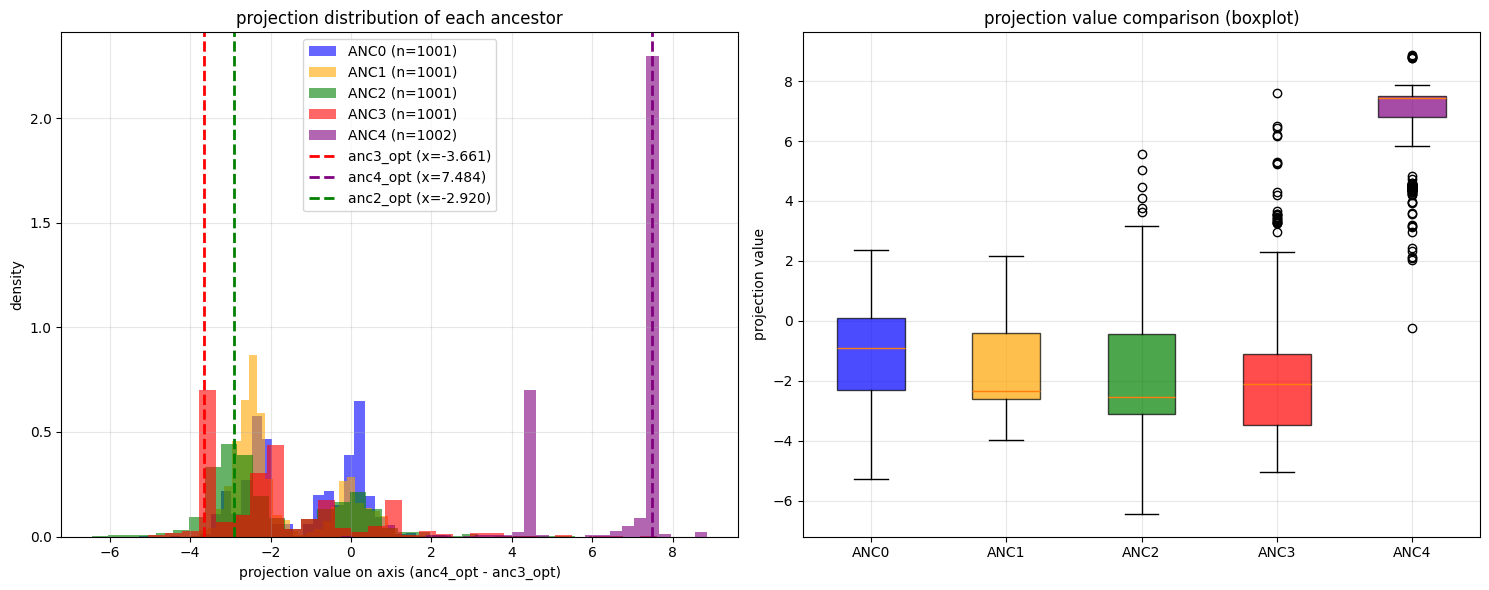

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# projection_axis = anc4_optimal_embedding - anc3_optimal_embedding
projection_axis = anc4_optimal_embedding - anc3_optimal_embedding
projection_axis = projection_axis / np.linalg.norm(projection_axis)

print(f"投影轴长度: {np.linalg.norm(projection_axis):.6f}")
print(f"投影轴维度: {projection_axis.shape}")

nodes_to_analyze = ['ANC0','ANC1','ANC2','ANC3','ANC4']
# nodes_to_analyze = ['ANC2','ANC3','ANC4']
xcl1_projection = xcl1_embedding @ projection_axis
anc3_opt_projection = anc3_optimal_embedding @ projection_axis
anc4_opt_projection = anc4_optimal_embedding @ projection_axis
anc0_opt_projection = anc0_optimal_embedding @ projection_axis
anc2_opt_projection = anc2_optimal_embedding @ projection_axis

node_projections = {}
projection_stats = {} 

for node_id in nodes_to_analyze:
    # 获取该节点的所有embeddings
    node_embeddings = contact_space.get_node_embeddings(node_id)
    
    # 投影到定义的轴上
    projections = node_embeddings @ projection_axis  # 点积运算
    
    node_projections[node_id] = projections

    # 计算统计量
    mean_proj = np.mean(projections)
    std_proj = np.std(projections, ddof=1)  # 样本标准差
    var_proj = np.var(projections, ddof=1)  # 样本方差
    
    # 存储统计信息
    projection_stats[node_id] = {
        'mean': mean_proj,
        'std': std_proj,
        'variance': var_proj,
        'min': projections.min(),
        'max': projections.max(),
        'range': projections.max() - projections.min()
    }
    
    print(f"{node_id}: n={len(projections)}")
    print(f"  范围: [{projections.min():.3f}, {projections.max():.3f}]")
    print(f"  均值: {mean_proj:.3f}")
    print(f"  标准差: {std_proj:.3f}")
    print(f"  方差: {var_proj:.3f}")
    print()
    
    print(f"{node_id}: {len(projections)} 个序列, 投影范围 [{projections.min():.3f}, {projections.max():.3f}]")


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 子图1: 分别显示每个祖先的分布
ax1 = axes[0]
colors = ['blue', 'orange', 'green', 'red','purple']
alphas = [0.6, 0.6, 0.6,0.6,0.6]


# colors = [ 'green', 'red','purple']
# alphas = [0.6,0.6,0.6]

for i, (node_id, projections) in enumerate(node_projections.items()):
    ax1.hist(projections, bins=30, alpha=alphas[i], density=True, 
            color=colors[i], label=f'{node_id} (n={len(projections)})')

# ax1.axvline(x=xcl1_projection, color='black', linestyle='--', linewidth=2, 
#            label=f'XCL1 (x={xcl1_projection:.3f})')
ax1.axvline(x=anc3_opt_projection, color='red', linestyle='--', linewidth=2, 
           label=f'anc3_opt (x={anc3_opt_projection:.3f})')
ax1.axvline(x=anc4_opt_projection, color='purple', linestyle='--', linewidth=2, 
           label=f'anc4_opt (x={anc4_opt_projection:.3f})')
# ax1.axvline(x=anc0_opt_projection, color='blue', linestyle='--', linewidth=2, 
#            label=f'anc0_opt (x={anc0_opt_projection:.3f})')
ax1.axvline(x=anc2_opt_projection, color='green', linestyle='--', linewidth=2, 
           label=f'anc2_opt (x={anc2_opt_projection:.3f})')
ax1.set_xlabel('projection value on axis (anc4_opt - anc3_opt)')
ax1.set_ylabel('density')
ax1.set_title('projection distribution of each ancestor')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 子图2: 箱线图比较
ax = axes[1]
projection_data = [node_projections[node] for node in nodes_to_analyze]

box_plot = ax.boxplot(projection_data, labels=nodes_to_analyze, patch_artist=True)

# 设置箱线图颜色
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('projection value')
ax.set_title('projection value comparison (boxplot)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


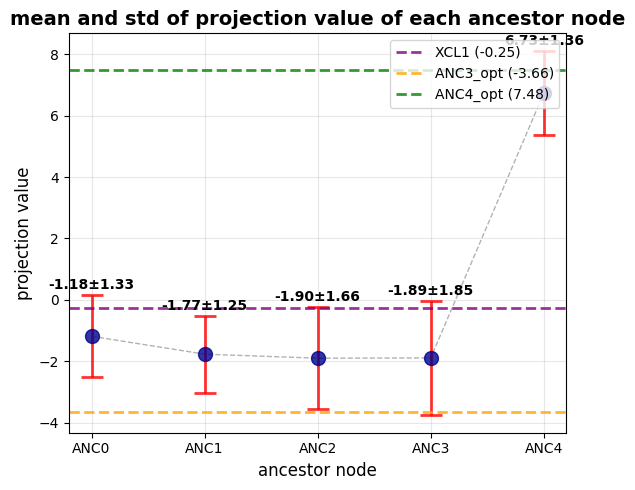


=== 变异系数 (CV = std/|mean|) ===
ANC0: 1.123
ANC1: 0.708
ANC2: 0.876
ANC3: 0.977
ANC4: 0.201
=== 统计汇总表 ===
节点     均值       标准差      方差       范围      
--------------------------------------------------
ANC0   -1.184   1.330    1.769    7.651   
ANC1   -1.767   1.251    1.565    6.124   
ANC2   -1.899   1.664    2.768    12.011  
ANC3   -1.889   1.845    3.404    12.673  
ANC4   6.732    1.356    1.839    9.120   


In [4]:
# 创建带误差棒的图表
import matplotlib.pyplot as plt
import numpy as np

# 准备数据
nodes = list(projection_stats.keys())
means = [projection_stats[node]['mean'] for node in nodes]
stds = [projection_stats[node]['std'] for node in nodes]

# 创建图形
fig, ax = plt.subplots(figsize=(6, 5))


# 子图2: 散点图 + 误差棒
x_positions = np.arange(len(nodes))
scatter = ax.errorbar(x_positions, means, yerr=stds, fmt='o', 
                      capsize=8, capthick=2, elinewidth=2, markersize=10,
                      color='darkblue', ecolor='red', alpha=0.8)

# 连接点的线
ax.plot(x_positions, means, '--', color='gray', alpha=0.6, linewidth=1)

# 添加数值标签
for i, (x, mean, std) in enumerate(zip(x_positions, means, stds)):
    ax.text(x, mean + std + 0.1, f'{mean:.2f}±{std:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_positions)
ax.set_xticklabels(nodes)
ax.set_xlabel('ancestor node', fontsize=12)
ax.set_ylabel('projection value', fontsize=12)
ax.set_title('mean and std of projection value of each ancestor node', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)



ax.axhline(y=xcl1_projection, color='purple', linestyle='--', 
            alpha=0.8, linewidth=2, label=f'XCL1 ({xcl1_projection:.2f})')
ax.axhline(y=anc3_opt_projection, color='orange', linestyle='--', 
            alpha=0.8, linewidth=2, label=f'ANC3_opt ({anc3_opt_projection:.2f})')
ax.axhline(y=anc4_opt_projection, color='green', linestyle='--', 
            alpha=0.8, linewidth=2, label=f'ANC4_opt ({anc4_opt_projection:.2f})')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()



# 计算变异系数 (Coefficient of Variation)
cv_values = [std/abs(mean) if mean != 0 else np.inf for mean, std in zip(means, stds)]
print(f"\n=== 变异系数 (CV = std/|mean|) ===")
for node, cv in zip(nodes, cv_values):
    print(f"{node}: {cv:.3f}")

print("=== 统计汇总表 ===")
print(f"{'节点':<6} {'均值':<8} {'标准差':<8} {'方差':<8} {'范围':<8}")
print("-" * 50)
for node_id in nodes_to_analyze:
    stats = projection_stats[node_id]
    print(f"{node_id:<6} {stats['mean']:<8.3f} {stats['std']:<8.3f} {stats['variance']:<8.3f} {stats['range']:<8.3f}")



Pearson Correlation

In [5]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def calculate_projection_correlations(anc_contact_embedding, projection_axis, critical_contacts, results, 
                                    node_name="ANC",node_id=None, verbose=True, rtol=1e-10, atol=1e-12):
    """
    计算祖先节点embedding各维度与投影轴的皮尔逊相关系数
    
    Args:
        anc_contact_embedding: 祖先节点的contact embedding矩阵 (n_samples, n_dimensions)
        projection_axis: 投影轴向量 (n_dimensions,)
        critical_contacts: 关键接触点列表
        results: contact difference分析结果（包含lost_contacts, new_contacts等）
        node_name: 节点名称，用于输出显示
        verbose: 是否显示详细输出
        rtol, atol: 常数检测的相对和绝对容忍度
        
    Returns:
        dict: 包含以下键值的字典
            - 'correlations': 相关系数数组
            - 'p_values': p值数组
            - 'valid_mask': 有效维度的mask
            - 'constant_dims': 常数维度列表
            - 'top_indices': 相关性最强的维度索引
            - 'projection_values': 投影值向量
            - 'stats': 统计信息字典
    """
    
    X = anc_contact_embedding
    N = X.shape[1]
    
    if verbose:
        print(f"=== {node_name} 投影相关性分析 ===")
        print(f"{node_name} embedding矩阵形状: {X.shape}")
    
    # 1. 计算投影值
    Y = X @ projection_axis
    if verbose:
        print(f"投影值向量形状: {Y.shape}")
    
    # 2. 常数检测函数
    def is_effectively_constant(arr, rtol=rtol, atol=atol):
        """检测数组是否实际上是常数"""
        arr_clean = arr[~np.isnan(arr)]
        if len(arr_clean) == 0:
            return True
        
        var = np.var(arr_clean)
        if var < atol:
            return True
        
        mean_val = np.mean(arr_clean)
        return np.allclose(arr_clean, mean_val, rtol=rtol, atol=atol)
    
    # 3. 检测常数维度
    constant_dims = []
    for i in range(N):
        if is_effectively_constant(X[:, i]):
            constant_dims.append(i)
    
    if verbose:
        print(f"实际常数维度数量: {len(constant_dims)}")
        if len(constant_dims) > 0:
            print(f"实际常数维度: {constant_dims[:20]}")
    
    # 4. 检查Y向量
    y_is_constant = is_effectively_constant(Y)
    if verbose:
        print(f"Y向量是否为常数: {y_is_constant}")
        
        if y_is_constant:
            print("错误：Y向量是常数，无法计算相关系数！")
            print(f"Y向量唯一值: {np.unique(Y)}")
        else:
            print(f"Y向量方差: {np.var(Y):.10f}")
    
    # 5. 计算相关系数
    correlations = []
    p_values = []
    valid_dims = []
    
    for i in range(N):
        if i in constant_dims:
            correlations.append(np.nan)
            p_values.append(np.nan)
            continue
        
        Xi = X[:, i]
        
        try:
            r, p = pearsonr(Xi, Y)
            
            if np.isnan(r) or np.isnan(p):
                correlations.append(np.nan)
                p_values.append(np.nan)
            else:
                correlations.append(r)
                p_values.append(p)
                valid_dims.append(i)
                
                # 打印前几个有效结果
                if verbose and len(valid_dims) <= 5:
                    contact_info = get_contact_info(critical_contacts, i)
                    print(f"维度 {i}: {contact_info:15s} | r = {r:.4f}, p = {p:.2e}")
                    
        except Exception as e:
            if verbose:
                print(f"维度 {i}: 计算出错 - {e}")
            correlations.append(np.nan)
            p_values.append(np.nan)
    
    correlations = np.array(correlations)
    p_values = np.array(p_values)
    
    # 6. 统计有效结果
    valid_mask = ~np.isnan(correlations)
    valid_corr = correlations[valid_mask]
    valid_p = p_values[valid_mask]
    
    # 7. 找出相关性最强的维度
    top_indices = []
    if len(valid_corr) > 0:
        valid_indices = np.where(valid_mask)[0]
        valid_abs_corr = np.abs(valid_corr)
        top_n = min(20, len(valid_corr))
        
        top_positions = np.argsort(valid_abs_corr)[-top_n:][::-1]
        top_indices = valid_indices[top_positions]
    
    # 8. 输出统计信息
    if verbose:
        print(f"\n=== {node_name} 相关系数统计 ===")
        print(f"总维度数: {N}")
        print(f"常数维度数: {len(constant_dims)}")
        print(f"有效维度数: {len(valid_corr)}")
        
        if len(valid_corr) > 0:
            print(f"相关系数范围: [{valid_corr.min():.4f}, {valid_corr.max():.4f}]")
            print(f"绝对值最大的相关系数: {valid_corr[np.argmax(np.abs(valid_corr))]:.4f}")
            print(f"显著相关的维度数量 (p < 0.05): {np.sum(valid_p < 0.05)}")
            print(f"显著相关的维度数量 (p < 0.01): {np.sum(valid_p < 0.01)}")
            
            print(f"\n=== {node_name} 相关性最强的{len(top_indices)}个维度 ===")
            for rank, idx in enumerate(top_indices):
                contact_info = get_contact_info(critical_contacts, idx,node_id=node_id)
                # contact_info = get_contact_info_with_pdb(critical_contacts, idx, msa_to_pdb_map,results['alternate_residue_types'],
                                            # node_id=node_id)
                contact_pair = critical_contacts[idx]
                
                # 判断接触类型
                if contact_pair in results['lost_contacts']:
                    contact_type = "LOST"
                elif contact_pair in results['new_contacts']:
                    contact_type = "GAIN"
                else:
                    contact_type = "COMMON"
                    
                print(f"{rank+1:2d}. 维度 {idx:3d}: {contact_info:15s} | r = {correlations[idx]:7.4f} | "
                      f"p = {p_values[idx]:.2e} ")
        else:
            print("没有有效的相关系数结果！")
    
    # 9. 准备统计信息
    stats = {
        'total_dims': N,
        'constant_dims_count': len(constant_dims),
        'valid_dims_count': len(valid_corr),
        'correlation_range': (valid_corr.min(), valid_corr.max()) if len(valid_corr) > 0 else (np.nan, np.nan),
        'max_abs_correlation': valid_corr[np.argmax(np.abs(valid_corr))] if len(valid_corr) > 0 else np.nan,
        'significant_05': np.sum(valid_p < 0.05) if len(valid_p) > 0 else 0,
        'significant_01': np.sum(valid_p < 0.01) if len(valid_p) > 0 else 0,
        'projection_variance': np.var(Y),
        'y_is_constant': y_is_constant
    }
    
    return {
        'correlations': correlations,
        'p_values': p_values,
        'valid_mask': valid_mask,
        'constant_dims': constant_dims,
        'top_indices': top_indices,
        'projection_values': Y,
        'valid_dims': valid_dims,
        'stats': stats
    }

# 使用示例
# ANC3分析
anc3_correlation_results = calculate_projection_correlations(
    anc3_contact_embedding, 
    projection_axis, 
    critical_contacts, 
    results, 
    node_name="ANC3",
    node_id="502"
)

# 获取结果
anc3_correlations = anc3_correlation_results['correlations']
anc3_p_values = anc3_correlation_results['p_values']
anc3_top_indices = anc3_correlation_results['top_indices']
anc3_stats = anc3_correlation_results['stats']

=== ANC3 投影相关性分析 ===
ANC3 embedding矩阵形状: (1001, 242)
投影值向量形状: (1001,)
实际常数维度数量: 29
实际常数维度: [20, 21, 26, 28, 29, 31, 34, 63, 64, 87, 89, 90, 91, 92, 108, 115, 116, 117, 118, 122]
Y向量是否为常数: False
Y向量方差: 3.4009797802
维度 0: 0-40            | r = 0.0192, p = 5.43e-01
维度 1: 0-44            | r = 0.0071, p = 8.23e-01
维度 2: 0-45            | r = -0.0705, p = 2.57e-02
维度 3: 0-46            | r = 0.0396, p = 2.11e-01
维度 4: 1-8             | r = 0.0353, p = 2.65e-01

=== ANC3 相关系数统计 ===
总维度数: 242
常数维度数: 29
有效维度数: 213
相关系数范围: [-0.4075, 0.8646]
绝对值最大的相关系数: 0.8646
显著相关的维度数量 (p < 0.05): 76
显著相关的维度数量 (p < 0.01): 52

=== ANC3 相关性最强的20个维度 ===
 1. 维度 208: 27Q(0.9)-60I(0.8) | r =  0.8646 | p = 8.43e-301 
 2. 维度 213: 31E(1.0)-60I(0.8) | r =  0.6972 | p = 1.39e-146 
 3. 维度 220: 32G(1.0)-60I(0.8) | r =  0.6964 | p = 4.43e-146 
 4. 维度 239: 36A(1.0)-60I(0.8) | r =  0.6963 | p = 4.99e-146 
 5. 维度 127: 49A(1.0)-60I(0.8) | r =  0.6963 | p = 4.99e-146 
 6. 维度 130: 51P(1.0)-60I(0.8) | r =  0.6962 | p = 5.44e-146 
 

In [6]:
anc4_correlation_results = calculate_projection_correlations(
    anc4_contact_embedding, 
    projection_axis, 
    critical_contacts, 
    results, 
    node_name="ANC4",
    node_id="507"
)

=== ANC4 投影相关性分析 ===
ANC4 embedding矩阵形状: (1002, 242)
投影值向量形状: (1002,)
实际常数维度数量: 77
实际常数维度: [1, 3, 4, 6, 8, 20, 21, 24, 25, 26, 27, 28, 29, 31, 34, 35, 36, 37, 39, 40]
Y向量是否为常数: False
Y向量方差: 1.8367873724
维度 0: 0-40            | r = -0.0096, p = 7.61e-01
维度 2: 0-45            | r = 0.0251, p = 4.28e-01
维度 5: 1-40            | r = -0.0096, p = 7.61e-01


维度 7: 1-45            | r = 0.0335, p = 2.89e-01
维度 9: 4-45            | r = 0.0264, p = 4.04e-01

=== ANC4 相关系数统计 ===
总维度数: 242
常数维度数: 77
有效维度数: 165
相关系数范围: [-0.1629, 0.9817]
绝对值最大的相关系数: 0.9817
显著相关的维度数量 (p < 0.05): 97
显著相关的维度数量 (p < 0.01): 91

=== ANC4 相关性最强的20个维度 ===
 1. 维度 208: 27K(1.0)-60V(0.8) | r =  0.9817 | p = 0.00e+00 
 2. 维度 220: 32G(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 3. 维度 239: 36A(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 4. 维度 130: 51P(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 5. 维度 119: 39F(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 6. 维度  93: 24Y(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 7. 维度 127: 49A(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 8. 维度 199: 25T(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
 9. 维度 114: 37V(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
10. 维度 213: 31E(1.0)-60V(0.8) | r =  0.9318 | p = 0.00e+00 
11. 维度 132: 53A(1.0)-60V(0.8) | r =  0.8791 | p = 0.00e+00 
12. 维度  69: 18I(0.6)-60V(0.8) | r =  0.6198 | p = 2.23e-107 
13. 维度 1

In [7]:
# 分析常数维度的原因
print("\n=== 分析常数维度的可能原因 ===")

# 方法1：检查ANC3序列在这些位置的氨基酸变异
def analyze_constant_dimension_sequences(dim_idx, contact_pair):
    """分析常数维度对应的序列变异情况"""
    
    pos1, pos2 = contact_pair
    print(f"\n分析维度 {dim_idx} (残基对 {pos1}-{pos2}):")

    mj_values = X[:, dim_idx]
    unique_values = np.unique(mj_values)
    print(f"MJ能量值数量: {unique_values}")
    
    # 获取ANC3的所有序列
    anc3_sequences = contact_space.get_node_sequences("ANC3")
    
    # 提取这两个位置的氨基酸组合
    aa_pairs = []
    for seq in anc3_sequences:
        if pos1 < len(seq) and pos2 < len(seq):
            aa1, aa2 = seq[pos1], seq[pos2]
            aa_pairs.append((aa1, aa2))
    
    # 统计氨基酸组合的频率
    from collections import Counter
    pair_counts = Counter(aa_pairs)
    
    print(f"氨基酸组合种类数: {len(pair_counts)}")
    print(f"最常见的组合:")
    for (aa1, aa2), count in pair_counts.most_common(5):
        percentage = count / len(aa_pairs) * 100
        print(f"  {aa1}-{aa2}: {count} 次 ({percentage:.1f}%)")
    
    # 如果只有一种组合，说明所有序列在这些位置完全相同
    if len(pair_counts) == 1:
        print("  → 所有序列在这两个位置的氨基酸完全相同！")
    else:
        print("  → 序列有变异，但MJ能量值相同（可能是不同氨基酸组合的MJ值恰好相等）")
    
    return pair_counts

# # 分析每个常数维度
# for dim_idx in constant_dims[:]:  
#     contact_pair = critical_contacts[dim_idx]
#     analyze_constant_dimension_sequences(dim_idx, contact_pair)


=== 分析常数维度的可能原因 ===


### Variance Contribution

维度方差

In [8]:
anc0_variance  = np.var(anc0_contact_embedding, axis=0, ddof=1)
print(f"ANC0方差形状: {anc0_variance.shape}") 
print(f"ANC0前5个接触对的方差: {anc0_variance[:5]}")

ANC0方差形状: (242,)
ANC0前5个接触对的方差: [0.19432851 1.16215387 0.1720536  1.18173842 0.39050689]


In [9]:
# 计算方差
anc2_variance = np.var(anc2_contact_embedding, axis=0, ddof=1)
anc3_variance = np.var(anc3_contact_embedding, axis=0, ddof=1)


anc4_variance = np.var(anc4_contact_embedding, axis=0, ddof=1)

anc3_2_var_diff_abs = np.abs(anc3_variance - anc2_variance)
sorted_indices = np.argsort(anc3_2_var_diff_abs)[::-1]  # 降序排序
# contact_info = get_contact_info(critical_contacts, idx,node_id=node_id)
top_k=20
print(f"\nANC2->ANC3 前{top_k}个最大的方差差异:")
for i in range(top_k):
    idx = sorted_indices[i]
    contact_info = get_contact_info(critical_contacts, idx)
    print(f"位置 {idx}: {contact_info:5s} | 方差差异: {anc3_2_var_diff_abs[idx]:.6f}")
# print("\n后10个最小的方差差异:")
# for i in range(-10,0):
#     idx = sorted_indices[i]
#     print(f"位置 {idx}: {anc3_2_var_diff_abs[idx]:.6f}")




ANC2->ANC3 前20个最大的方差差异:
位置 116: 39-49 | 方差差异: 5.001998
位置 123: 49-55 | 方差差异: 5.001998
位置 124: 49-56 | 方差差异: 5.001998
位置 89: 24-48 | 方差差异: 4.999674
位置 91: 24-56 | 方差差异: 4.998851
位置 87: 24-41 | 方差差异: 4.998844
位置 195: 24-36 | 方差差异: 4.998547
位置 90: 24-49 | 方差差异: 4.996723
位置 63: 17-41 | 方差差异: 4.982767
位置 21: 8-38  | 方差差异: 4.879819
位置 115: 38-49 | 方差差异: 4.875450
位置 64: 17-59 | 方差差异: 4.798884
位置 192: 22-38 | 方差差异: 4.474444
位置 165: 12-41 | 方差差异: 4.400596
位置 221: 33-51 | 方差差异: 4.139661
位置 39: 12-48 | 方差差异: 4.015277
位置 37: 12-39 | 方差差异: 3.985182
位置 43: 12-55 | 方差差异: 3.978155
位置 82: 22-44 | 方差差异: 3.970761
位置 40: 12-49 | 方差差异: 3.876239


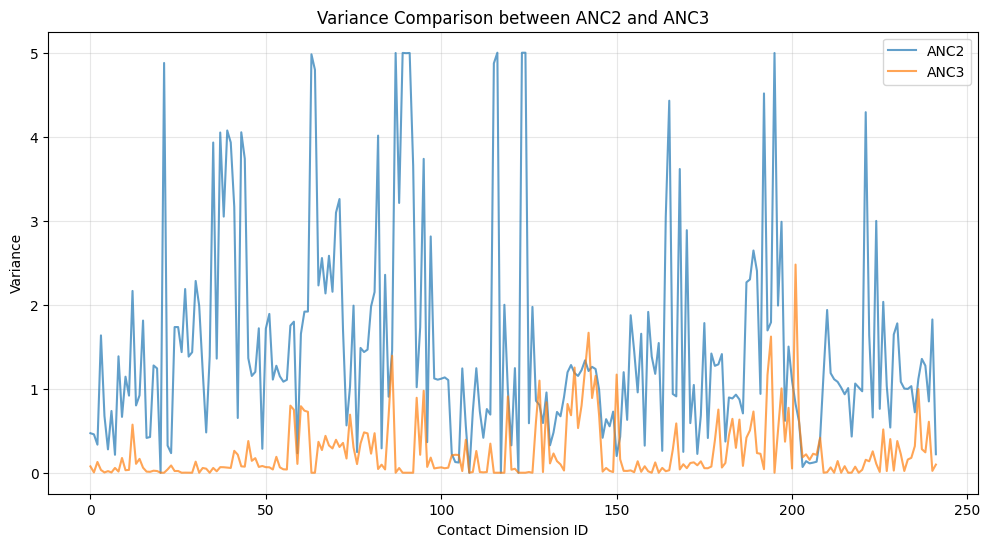

In [10]:
# 绘制方差对比图
plt.figure(figsize=(12, 6))
x = np.arange(len(anc2_variance))
plt.plot(x, anc2_variance, label='ANC2', alpha=0.7)
plt.plot(x, anc3_variance, label='ANC3', alpha=0.7)
plt.xlabel('Contact Dimension ID')
plt.ylabel('Variance')
plt.title('Variance Comparison between ANC2 and ANC3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

我绘制了anc2和anc3的方差，发现分维度的话 anc2远比anc3方差高。其实我觉得这里的方差计算，其实只是反应原来的概率分布的情况。和我们前面做了投影之后的方差完全是两回事

In [11]:
# Print differences between anc2 and anc3
print("Differences between anc2 and anc3:")
for i, (aa2, aa3) in enumerate(zip(anc2_optimal, anc3_optimal)):
    if aa2 != aa3:
        print(f"{i}: {aa2}->{aa3}")

Differences between anc2 and anc3:
3: R->K
6: V->I
7: R->K
9: L->V
10: K->S
11: Y->L
18: L->I
19: K->N
20: R->S
23: S->T
32: C->G
33: N->S
34: I->M
37: I->V
40: T->I
42: K->R
43: K->R
45: R->I
53: E->A
62: H->T
63: L->I
66: K->R
67: A->T
68: K->T
69: K->T


### 更换投影轴 todo

找出所有“状态特异性接触”（Fold 1有而Fold 2无，反之亦然）。创建一个N维向量，其中“Fold 1”接触的维度为 -1，“Fold 2”接触的维度为 +1。这个新向量代表了一个“通用变构轴”。

需要考虑mj potential的具体值

检验： 将所有系综（ANC0-ANC4）投影到这个“通用轴”上。ANC3的投影方差是否仍然是峰值？

### 协方差矩阵

我们要定量地证明ANC3的方差是“定向的”，而ANC2的方差是“随机的”。

In [12]:
# rowvar=False 是关键！表示每列是一个变量（特征），每行是一个观测值（样本）
anc2_cov_matrix = np.cov(anc2_contact_embedding, rowvar=False)
anc3_cov_matrix = np.cov(anc3_contact_embedding, rowvar=False)
anc4_cov_matrix = np.cov(anc4_contact_embedding, rowvar=False)


# 查看结果
print(f"协方差矩阵形状: {anc2_cov_matrix.shape}")  # (242, 242)
print(f"对角线元素（方差）: {np.diag(anc2_cov_matrix)[:5]}")  # 前5个接触对的方差
print(f"协方差矩阵是对称的: {np.allclose(anc2_cov_matrix, anc2_cov_matrix.T)}")  # True



协方差矩阵形状: (242, 242)
对角线元素（方差）: [0.47037766 0.45697918 0.33422699 1.63556867 0.6761607 ]
协方差矩阵是对称的: True


In [13]:
def pca_from_covariance(cov_matrix):
    """
    对协方差矩阵进行主成分分析
    
    参数:
        cov_matrix: numpy数组，形状为(n_dimensions, n_dimensions)
                   协方差矩阵
    
    返回:
        dict: 包含以下键值
            - 'eigenvalues': 特征值（已排序，从大到小）
            - 'eigenvectors': 特征向量（主成分方向）
            - 'explained_variance_ratio': 解释方差比例
            - 'cumulative_variance': 累积解释方差比例
    """
    # 1. 对协方差矩阵做特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # 2. 按特征值从大到小排序
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 3. 计算解释方差比例
    total_variance = eigenvalues.sum()
    explained_variance_ratio = eigenvalues / total_variance
    
    # 4. 计算累积解释方差
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance
    }


# 对ANC2的协方差矩阵做PCA
anc2_pca = pca_from_covariance(anc2_cov_matrix)

print("分析ANC2 PC1")
# 查看PC1的解释效果
pc1_variance_ratio = anc2_pca['explained_variance_ratio'][0]
print(f"PC1解释方差比例: {pc1_variance_ratio:.4f} ({pc1_variance_ratio*100:.2f}%)")

# 查看前5个主成分的解释效果
print(f"\n前10个主成分的解释方差比例:")
for i in range(10):
    ratio = anc2_pca['explained_variance_ratio'][i]
    cum = anc2_pca['cumulative_variance'][i]
    pc_direction = anc2_pca['eigenvectors'][:, i]
    cos_angle = np.dot(pc_direction, projection_axis) / (np.linalg.norm(pc_direction) * np.linalg.norm(projection_axis))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_rad = np.arccos(cos_angle)
    print(f"  PC{i+1}: {ratio*100:.2f}% | 累积: {cum*100:.2f}% | 余弦值: {cos_angle:.4f} 夹角: {np.degrees(angle_rad):.4f} 度")


分析ANC2 PC1
PC1解释方差比例: 0.1025 (10.25%)

前10个主成分的解释方差比例:
  PC1: 10.25% | 累积: 10.25% | 余弦值: 0.0318 夹角: 88.1768 度
  PC2: 7.72% | 累积: 17.97% | 余弦值: 0.0024 夹角: 89.8652 度
  PC3: 5.91% | 累积: 23.89% | 余弦值: -0.0227 夹角: 91.3022 度
  PC4: 5.48% | 累积: 29.37% | 余弦值: 0.0123 夹角: 89.2956 度
  PC5: 4.80% | 累积: 34.17% | 余弦值: -0.0038 夹角: 90.2174 度
  PC6: 4.26% | 累积: 38.43% | 余弦值: 0.0460 夹角: 87.3649 度
  PC7: 3.31% | 累积: 41.74% | 余弦值: -0.0564 夹角: 93.2347 度
  PC8: 3.19% | 累积: 44.93% | 余弦值: 0.0695 夹角: 86.0142 度
  PC9: 2.93% | 累积: 47.86% | 余弦值: -0.0326 夹角: 91.8698 度
  PC10: 2.87% | 累积: 50.72% | 余弦值: 0.0010 夹角: 89.9405 度


In [14]:
anc3_pca = pca_from_covariance(anc3_cov_matrix)

print("分析ANC3 PC1")
# 查看前5个主成分的解释效果
print(f"\n前10个主成分的解释方差比例:")
for i in range(10):
    ratio = anc3_pca['explained_variance_ratio'][i]
    cum = anc3_pca['cumulative_variance'][i]
    pc_direction = anc3_pca['eigenvectors'][:, i]
    cos_angle = np.dot(pc_direction, projection_axis) / (np.linalg.norm(pc_direction) * np.linalg.norm(projection_axis))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_rad = np.arccos(cos_angle)
    print(f"  PC{i+1}: {ratio*100:.2f}% | 累积: {cum*100:.2f}% | 余弦值: {cos_angle:.4f} 夹角: {np.degrees(angle_rad):.4f} 度")


分析ANC3 PC1

前10个主成分的解释方差比例:
  PC1: 10.56% | 累积: 10.56% | 余弦值: 0.2576 夹角: 75.0707 度
  PC2: 10.27% | 累积: 20.83% | 余弦值: -0.3327 夹角: 109.4326 度
  PC3: 9.32% | 累积: 30.14% | 余弦值: -0.5031 夹角: 120.2022 度
  PC4: 7.96% | 累积: 38.10% | 余弦值: 0.0644 夹角: 86.3080 度
  PC5: 7.64% | 累积: 45.75% | 余弦值: 0.0945 夹角: 84.5782 度
  PC6: 6.60% | 累积: 52.35% | 余弦值: -0.0684 夹角: 93.9230 度
  PC7: 5.11% | 累积: 57.46% | 余弦值: 0.0608 夹角: 86.5135 度
  PC8: 4.81% | 累积: 62.27% | 余弦值: -0.0352 夹角: 92.0165 度
  PC9: 3.77% | 累积: 66.04% | 余弦值: -0.4141 夹角: 114.4607 度
  PC10: 3.59% | 累积: 69.63% | 余弦值: -0.1967 夹角: 101.3461 度


In [15]:
anc4_pca = pca_from_covariance(anc4_cov_matrix)

print("分析ANC4 PC1")
# 查看PC1的解释效果
pc1_variance_ratio = anc4_pca['explained_variance_ratio'][0]
print(f"PC1解释方差比例: {pc1_variance_ratio:.4f} ({pc1_variance_ratio*100:.2f}%)")

# 查看前5个主成分的解释效果
print(f"\n前5个主成分的解释方差比例:")
for i in range(5):
    ratio = anc4_pca['explained_variance_ratio'][i]
    cum = anc4_pca['cumulative_variance'][i]
    pc_direction = anc4_pca['eigenvectors'][:, i]
    cos_angle = np.dot(pc_direction, projection_axis) / (np.linalg.norm(pc_direction) * np.linalg.norm(projection_axis))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_rad = np.arccos(cos_angle)
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%) | 累积: {cum:.4f} ({cum*100:.2f}%) | 余弦值: {cos_angle:.4f} 夹角: {np.degrees(angle_rad):.4f} 度")


分析ANC4 PC1
PC1解释方差比例: 0.3461 (34.61%)

前5个主成分的解释方差比例:
  PC1: 0.3461 (34.61%) | 累积: 0.3461 (34.61%) | 余弦值: 0.0672 夹角: 86.1466 度
  PC2: 0.2338 (23.38%) | 累积: 0.5800 (58.00%) | 余弦值: 0.5306 夹角: 57.9512 度
  PC3: 0.1337 (13.37%) | 累积: 0.7137 (71.37%) | 余弦值: -0.0548 夹角: 93.1429 度
  PC4: 0.0760 (7.60%) | 累积: 0.7897 (78.97%) | 余弦值: -0.0099 夹角: 90.5651 度
  PC5: 0.0497 (4.97%) | 累积: 0.8394 (83.94%) | 余弦值: 0.0177 夹角: 88.9843 度


### 迭代式突变

In [16]:
anc_prob_file = f"/yezhirui/evo_probe/data/anc_prob.txt" 
anc2_prob = parse_ancestral_probs(anc_prob_file, "501")
anc3_prob = parse_ancestral_probs(anc_prob_file, "502")
anc4_prob = parse_ancestral_probs(anc_prob_file, "507")



In [ ]:
import numpy as np
import copy
from typing import Dict, List, Tuple

def create_hybrid_sequences(
    source_prob: Dict,
    target_prob: Dict,
    mutation_list: List[int],
    n_samples: int = 1000,
    output_file: str = None,
    amino_acids: str = "ARNDCQEGHILKMFPSTWYV"
) -> Tuple[Dict, np.ndarray]:
    """
    创建混合祖先概率分布并采样序列
    
    将source_prob中指定突变位置的概率分布替换为target_prob对应位置的分布，
    然后基于混合概率分布采样序列。
    """
    # 创建混合概率分布（深拷贝避免修改原始数据）
    hybrid_prob = copy.deepcopy(source_prob)
    
    # 替换突变位置的概率分布
    for pos in mutation_list:
        if pos in target_prob:
            hybrid_prob[pos] = target_prob[pos].copy()
        else:
            print(f"警告: 位置 {pos} 在target_prob中不存在，保持source_prob的分布")
    
    # 获取所有位置并排序
    positions = sorted(hybrid_prob.keys())
    n_positions = len(positions)
    
    # 采样序列
    sequences = np.zeros((n_samples, n_positions), dtype='U1')
    
    for i, pos in enumerate(positions):
        prob_dict_pos = hybrid_prob[pos]  # {aa: prob} 字典
        
        # 将字典转换为按amino_acids顺序的数组
        prob_array = np.array([prob_dict_pos.get(aa, 0.0) for aa in amino_acids])
        
        # 确保概率和为1（归一化）
        prob_array = prob_array / prob_array.sum()
        
        # 基于概率分布采样
        aa_indices = np.random.choice(
            len(amino_acids), 
            size=n_samples, 
            p=prob_array
        )
        sequences[:, i] = [amino_acids[idx] for idx in aa_indices]
    
    # 如果指定了输出文件，写入序列
    if output_file:
        with open(output_file, 'w') as f:
            f.write(f"# Hybrid sequences (n={n_samples})\n")
            f.write(f"# Source positions: {len(source_prob)}, Mutations: {len(mutation_list)}\n")
            f.write(f"# Positions: {positions[0]}-{positions[-1]}\n")
            for idx, seq in enumerate(sequences):
                seq_str = ''.join(seq)
                f.write(f">seq_{idx+1}\n{seq_str}\n")
        print(f"已写入 {n_samples} 条序列到 {output_file}")
    
    return hybrid_prob, sequences


def sample_from_prob_distribution(
    prob_dict: Dict,
    n_samples: int = 1,
    amino_acids: str = "ARNDCQEGHILKMFPSTWYV"
) -> np.ndarray:
    """
    从概率分布字典中采样序列
    """
    positions = sorted(prob_dict.keys())
    n_positions = len(positions)
    sequences = np.zeros((n_samples, n_positions), dtype='U1')
    
    for i, pos in enumerate(positions):
        prob_dict_pos = prob_dict[pos]  # {aa: prob} 字典
        # 将字典转换为按amino_acids顺序的数组
        prob_array = np.array([prob_dict_pos.get(aa, 0.0) for aa in amino_acids])
        prob_array = prob_array / prob_array.sum()  # 归一化
        aa_indices = np.random.choice(len(amino_acids), size=n_samples, p=prob_array)
        sequences[:, i] = [amino_acids[idx] for idx in aa_indices]
    
    return sequences


def write_fasta(sequences: np.ndarray, output_file: str, prefix: str = "seq"):
    """
    将序列数组写入FASTA格式文件
    """
    with open(output_file, 'w') as f:
        for idx, seq in enumerate(sequences):
            seq_str = ''.join(seq)
            f.write(f">{prefix}_{idx+1}\n{seq_str}\n")

In [ ]:
# 基本使用
hybrid_prob, sequences = create_hybrid_sequences(
    source_prob=anc2_prob,
    target_prob=anc3_prob,
    mutation_list=[10, 20, 30, 45, 67],  # 你的突变位置列表
    n_samples=1000,
    output_file="/yezhirui/evo_probe/data/out/hybrid__anc2_anc3_sequences_test.fasta"
)

# 检查结果
print(f"混合概率分布位置数: {len(hybrid_prob)}")
print(f"采样序列形状: {sequences.shape}")
print(f"第一条序列: {''.join(sequences[0])}")

# 如果只想采样而不创建混合
# sequences_only = sample_from_prob_distribution(anc2_prob, n_samples=1000)

# 如果已有序列，只想写入文件
# write_fasta(sequences, "output.fasta", prefix="hybrid")

AttributeError: 'dict' object has no attribute 'sum'